In [1]:
import numpy as np

In [2]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1
            
#read in the fasta files and one-hot encode
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open("sp1_ml_datasets/ls-gkm/test_pos_200bp.fa"))
              if i%2==1]
#filter out any sequences that contain 'N's
onehot_data = [np.array(one_hot_encode_along_channel_axis(x))
                         for x in fasta_seqs if ('N' not in x)]
print("Num onehot sequences:",len(onehot_data))

#read in the importance scores and hypothetical importance scores
#filter out any sequences that contain 'N's
hyp_impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("sp1_ml_datasets/ls-gkm/gkmexp_pos_hypimpscores.txt")
],fasta_seqs) if 'N' not in w[1]]

impscores = [w[0] for w in zip([
    np.array( [[float(z) for z in y.split(",")]
                for y in x.rstrip().split("\t")[2].split(";")])
    for x in open("sp1_ml_datasets/ls-gkm/gkmexp_pos_impscores.txt")
],fasta_seqs) if 'N' not in w[1]]

#Perform a sanity check to make sure that the importance score are the same as the
# hypothetical scores multiplied elementwise with the one-hot encoding; for this
# reason, it is not technically necessary to compute the importance scores if the
# hypothetical scores are also computed
assert (np.max([np.max(np.abs(z*y - x))
                for x,y,z in zip(impscores,
                                 onehot_data,
                                 hyp_impscores)]))==0

dnshuff_impscores = [np.array( [[float(z) for z in y.split(",")]
                           for y in x.rstrip().split("\t")[2].split(";")])
                     for x in open("sp1_ml_datasets/ls-gkm/gkmexp_neg_impscores.txt")]

Num onehot sequences: 200


In [3]:
def normalize_scores(impscores, hyp_impscores, onehot_data):
  #normalize the hyp scores such that, at each position, hypothetical importance
  # scores that have the same sign as the original importance score all sum
  # up to the original importance score value. The rationale is that if
  # multiple different bases at a position could produce a similar score,
  # the specific identity of each individual base is less important.
  #Empirically, hypothetical scores like these appear to work better for
  # motif discovery. Using normalized importance scores derived by taking
  # the elementwise product of the normalized hypothetical scores and
  # the one-hot encoding also seems to reduce noise.
  normed_hyp_impscores = []
  normed_impscores = []
  for i in range(len(impscores)):
      imp_score_each_pos = np.sum(impscores[i],axis=-1)
      imp_score_sign_each_pos = np.sign(imp_score_each_pos)
      hyp_scores_same_sign_mask = (np.sign(hyp_impscores[i])
                                   *imp_score_sign_each_pos[:,None] > 0)
      hyp_scores_same_sign_imp_scores_sum = np.sum(
          hyp_impscores[i]*hyp_scores_same_sign_mask,axis=-1)
      norm_ratio = imp_score_each_pos/hyp_scores_same_sign_imp_scores_sum
      norm_hyp = hyp_impscores[i]*norm_ratio[:,None]
      normed_hyp_impscores.append(norm_hyp)
      normed_impscores.append(norm_hyp*onehot_data[i])
  return normed_impscores, normed_hyp_impscores

normed_impscores, normed_hyp_impscores = normalize_scores(
  impscores=impscores, hyp_impscores=hyp_impscores, onehot_data=onehot_data)

In [4]:
# ! pip install modisco==0.5.1.1

TF-MoDISco is using the TensorFlow backend.
/home/layaasiv/miniconda3/envs/tf_modisco_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.kde module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Idx 176 total imp 1.4213296566999998
Before normalization


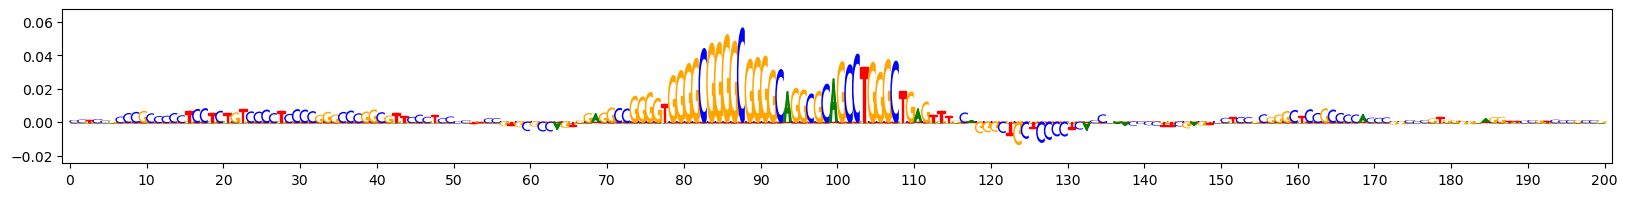

After normalization


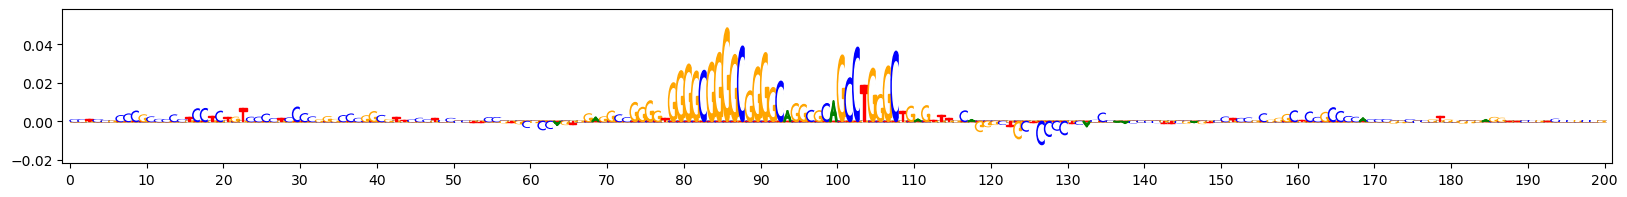

Idx 120 total imp 1.3859166121
Before normalization


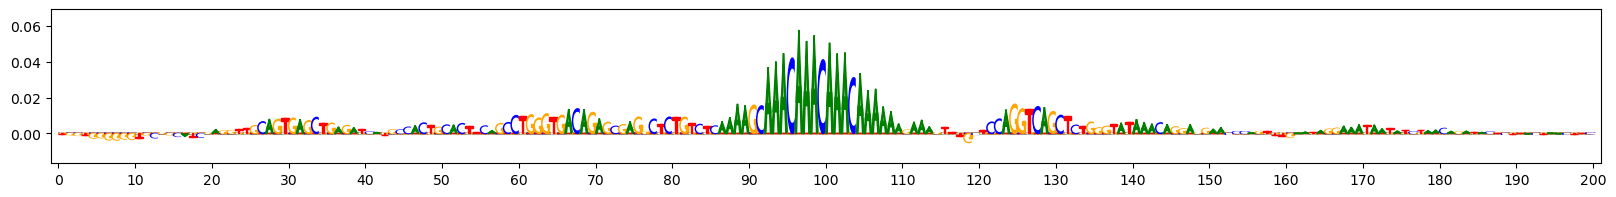

After normalization


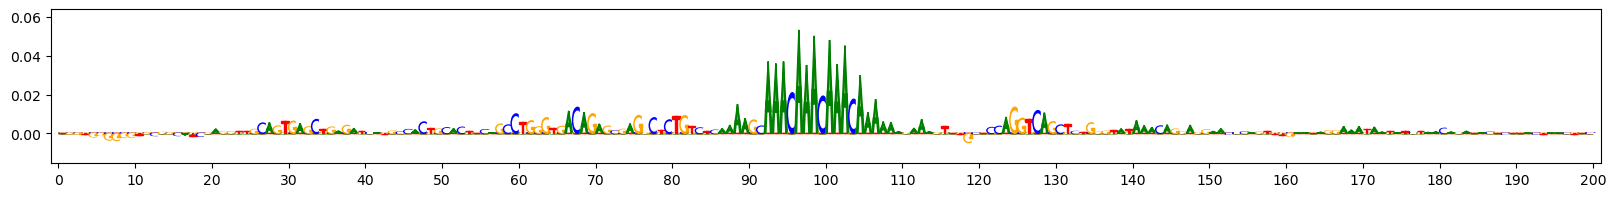

Idx 152 total imp 1.2699310472
Before normalization


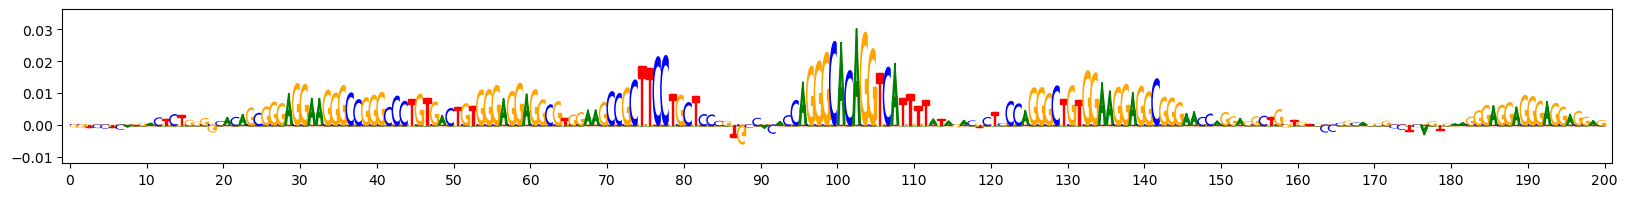

After normalization


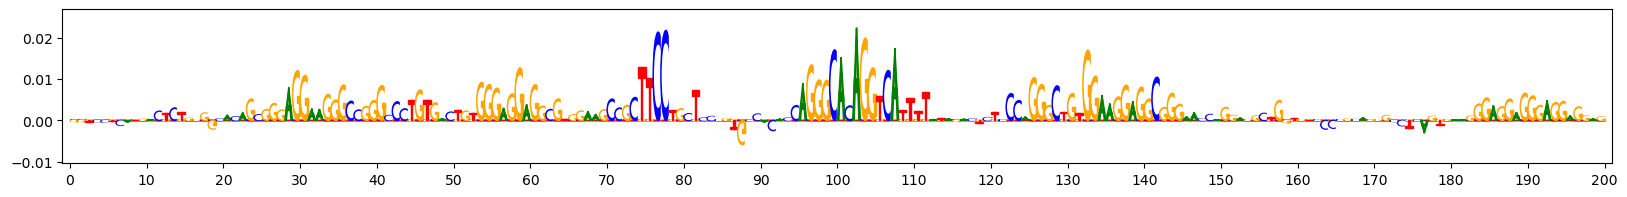

Idx 161 total imp 1.20842162706
Before normalization


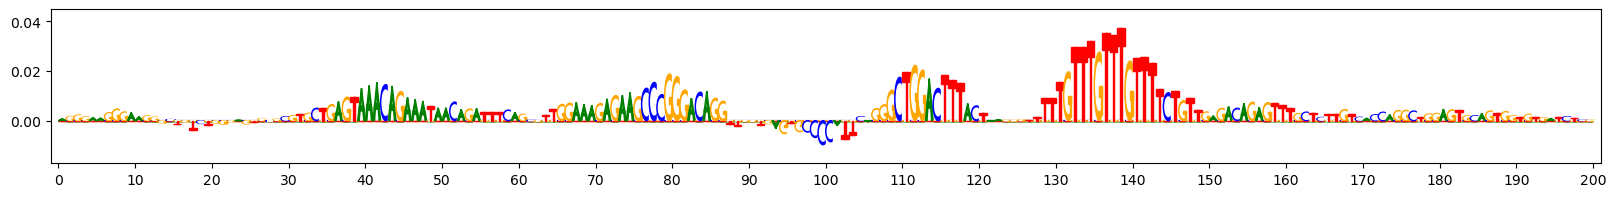

After normalization


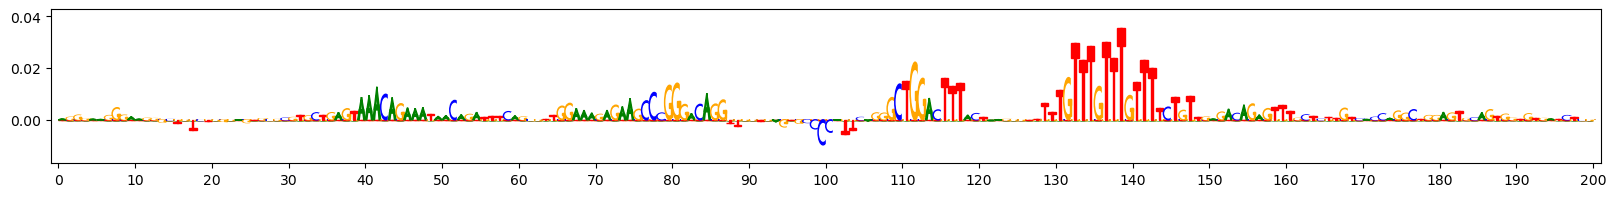

Idx 146 total imp 1.1299149340999999
Before normalization


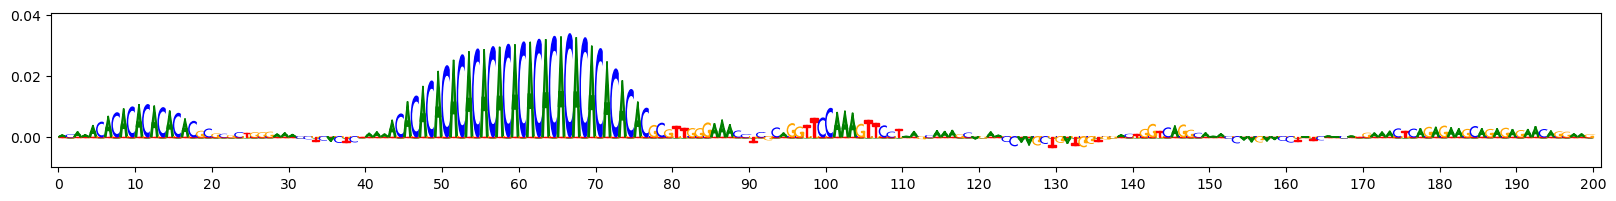

After normalization


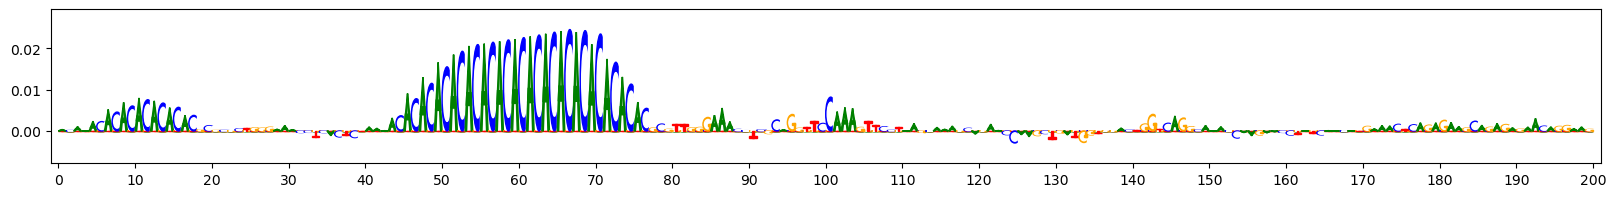

In [5]:
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
plt.style.use('default')

sorted_indices = [x[0] for x in
                  sorted(enumerate([np.sum(x) for x in impscores]),
                         key=lambda x: -x[1])]
for idx in sorted_indices[:5]:
    print("Idx",idx,"total imp",np.sum(impscores[idx]))
    print("Before normalization")
    viz_sequence.plot_weights(impscores[idx], subticks_frequency=10)
    print("After normalization")
    viz_sequence.plot_weights(normed_impscores[idx], subticks_frequency=10)

In [9]:
import modisco.nearest_neighbors

def patched_call(self, affinity_mat):
    # This is the core fix: 
    # 1. Take the negative of the affinity matrix to get 'distance'
    # 2. Force all negative values to 0.0 (clip)
    # 3. Ensure the matrix is float64 to avoid precision issues
    dist_mat = -affinity_mat
    dist_mat[dist_mat < 0] = 0
    
    return self.nn_object.fit(dist_mat).kneighbors(
            X=dist_mat,
            n_neighbors=min(self.n_neighbors+1, dist_mat.shape[0]),
            return_distance=True)

# Overwrite the MoDISco internal method with our patched version
modisco.nearest_neighbors.MxtsNeighborGenerator.__call__ = patched_call

print("MoDISco NearestNeighbors patch applied.")

AttributeError: module 'modisco.nearest_neighbors' has no attribute 'MxtsNeighborGenerator'

On task task0
Computing windowed sums on original
Generating null dist
Computing threshold
Thresholds from null dist were -0.364540778  and  0.06762436500000002
Passing windows frac was 0.3055833333333333 , which is above  0.2 ; adjusting
Final raw thresholds are -0.10427808839999998  and  0.10427808839999998
Final transformed thresholds are -0.8  and  0.8


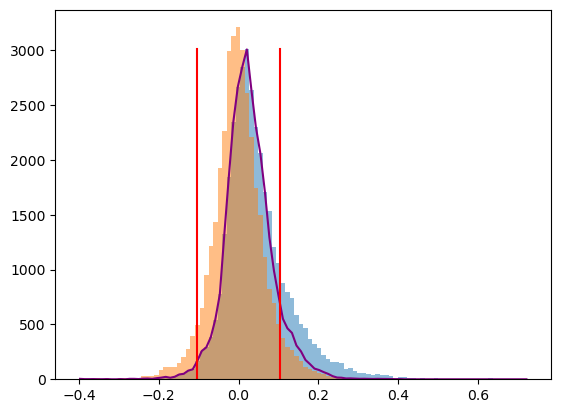

Got 400 coords
After resolving overlaps, got 400 seqlets
Across all tasks, the weakest transformed threshold used was: 0.7999999000000001
400 identified in total
Reducing weak_threshold_for_counting_sign to match weakest_transformed_thresh, from 0.8 to 0.7999999000000001
1 activity patterns with support >= 100 out of 3 possible patterns
Metacluster sizes:  [356]
Idx to activities:  {0: '1'}
On metacluster 0
Metacluster size 356
Relevant tasks:  ('task0',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 356
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.48 s
Starting affinity matrix computations
Normalization computed in 0.01 s
Cosine similarity mat computed in 0.02 s
Normalization computed in 0.01 s
Cosine similarity mat computed in 0.02 s
Finished affinity matrix computations in 0.04 s
(Round 1) Compute nearest neighbors from coarse affmat


ValueError: Negative values in data passed to precomputed distance matrix.

In [8]:
from modisco.visualization import viz_sequence
from matplotlib import pyplot as plt
plt.style.use('default')
import h5py
import numpy as np
import modisco

#I sum up the null distribution importance scores at each position
# to get the perpos importance scores
# of the null distribution. I decided to use
# the unnormalized dnshuff_impscores (rather than normalized versions
# of these scores) as this made for a more stringent null distribution.
# Figuring out the best way to generate a null distribution for these scores
# is still an open problem.
dnshuff_perposimp = [np.sum(x,axis=-1) for x in dnshuff_impscores]

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
          #target_seqlet_fdr controls the stringency of the threshold used.
          # the default value is 0.2
          target_seqlet_fdr=0.50,
          #min_passing_windows_frac and max_passing_windows_frac can be used
          # to manually adjust the percentile cutoffs for importance
          # scores if you feel that the cutoff
          # defined by the null distribution is too stringent or too
          # lenient. The default values are 0.03 and 0.2 respectively.
          #min_passing_windows_frac=0.03,
          #max_passing_windows_frac=0.2
          seqlets_to_patterns_factory=
              modisco.tfmodisco_workflow
                     .seqlets_to_patterns
                     .TfModiscoSeqletsToPatternsFactory(
                  #kmer_len, num_gaps and num_mismatches are used to
                  # derive kmer embeddings for coarse-grained affinity
                  # matrix calculation. kmer_len=6, num_gaps=1
                  # and num_mismatches=0 means
                  # that kmer embeddings using 6-mers with 1 gap will be
                  # used. The default is to use longer kmers, but this
                  # can take a while to run and can lead to
                  # out-of-memory errors on some systems.
                  # Empirically, 6-mers with 1-gap
                  # seem to give good results.
                  kmer_len=6, num_gaps=1,
                  num_mismatches=0,
          ),
     )(
  #There is only one task, so we just call this 'task0'
  task_names=["task0"],
  contrib_scores={'task0': impscores},                
  hypothetical_contribs={'task0': hyp_impscores},
  one_hot=onehot_data,
  null_per_pos_scores={'task0': dnshuff_perposimp})

In [9]:
from modisco.aggregator import TrimToBestWindow

trimmer = TrimToBestWindow(window_size=30, track_names=["task0_contrib_scores"])
metacluster_dict = tfmodisco_results.metacluster_idx_to_submetacluster_results

for metacluster_key in metacluster_dict.keys():
    print(f"--- Processing {metacluster_key} ---")
    
    # Safely access the patterns for this specific metacluster
    patterns = metacluster_dict[metacluster_key].seqlets_to_patterns_result.patterns
    
    if patterns is not None:
        for i, pattern in enumerate(trimmer(patterns)):
            print("num seqlets",len(pattern.seqlets))
            print("fwd seq PWM")
            viz_sequence.plot_weights(viz_sequence.ic_scale(
                pattern["sequence"].fwd, background=np.array([0.25,0.25,0.25,0.25])))
            print("Contrib scores")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"].fwd)
            print("Hyp contrib scores")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].fwd)

            print("rev seq PWM")
            viz_sequence.plot_weights(viz_sequence.ic_scale(
              pattern["sequence"].rev, background=np.array([0.25,0.25,0.25,0.25])))
            print("Contrib scores")
            viz_sequence.plot_weights(pattern["task0_contrib_scores"].rev)
            print("Hyp contrib scores")
            viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"].rev)
    else:
        print(f"No patterns found in {metacluster_key}")

In [10]:
print("Metaclusters found:", list(metacluster_dict.keys()))
if hasattr(tfmodisco_results, 'null_stats'):
    print("Null stats found (MoDISco ran but may have found nothing).")

Metaclusters found: []
